# Neural Networks in 100 lines of pure Python
- [blog_link](https://eisenjulian.github.io/deep-learning-in-100-lines/)
- [Pytorch nn module tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

In [95]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

font = {'weight' : 'bold',
        'size'   : 22}
mpl.rc('font', **font)

import warnings
warnings.simplefilter('ignore')

In [91]:
sorted(mpl.style.available)

['Solarize_Light2',
 '_classic_test',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

## Param Class

We can start with a class that encapsulates 
- tensor
- its gradients. 

The tensor can be anything like numpy array or torch array

In [28]:
class Parameter():
    def __init__(self, tensor):
        self.tensor = tensor
        self.gradient = np.zeros_like(self.tensor)

## Layer Class

Now we can create the layer class, the key idea is that during a forward pass (`Forward()`) we return both 

- layer output 
- `function`

The `function` will have the following signature:

```py
def function(input):
    """
    input (tensor): gradient of the loss with respect to the outputs
    return (tensor): the gradient with respect to the inputs, 
                    updating the weight gradients in the process
    """
    output = do_operation(input)
    return output

```

This is because while evaluating the model layer by layer there's no way to calculate the gradients if we don't know the final loss yet, instead the best thing you can do is return a function that CAN calculate the gradient later. And that function will only be called after we completed the forward evaluation, when you know the loss and you have all the necessary info to compute the gradients in that layer.


The training process will then have three steps, calculate the forward step, then the backward steps accumulate the gradients, and finally updating the weights. It’s important to do this at the end	since weights can be reused in multiple layers and we don’t want to mutate the weights before time.

In [44]:
class Layer:
    def __init__(self):
        self.parameters = []

    def forward(self, X):
        return X, lambda D: D

    def build_param(self, tensor):
        """
        tensor (numpy matrix)
        return:
            param (Parameter)
        """
        param = Parameter(tensor)
        self.parameters.append(param)
        return param
    
    def update(self, optimizer):
        for param in self.parameters: optimizer.update(param)

It's standard to delegate the job of updating the parameters to an optimizer, which receives an instance of a parameter after every batch. The simplest and most known optimization method out there is the mini-batch stochastic gradient descent

### Code Analysis
Also look at line 6, where it's returning a lambda. Here it's returning a lambda function that can be applied later with the appropriate argument. 

How a returned lambda function can work? 

Lets see an example

```py
def fun(n):
    """
    return a lambda function with the increment size
    """
    return lambda x: x+n

x = 3
inc3 = fun(3)
inc3(x) ## this will increase the x's value by 3
ans: 6

inc5 = fun(5)
inc5(x) ## this will increase the x's value by 3
ans: 8
```

## SGD Optimizer Class

In [40]:
class SGDOptimizer():
    def __init__(self, lr=0.1):
        self.lr = lr

    def update(self, param):
        """
        the tensors are updated, but not the gradients. they are filled with 0. Why ????
        look at the backward() definition in Class Linear. In the backward(), the gradients are updated.
        """
        param.tensor -= self.lr * param.gradient
        param.gradient.fill(0) 

Next build our `Linear Layer` extending the `Class Layer`

## Linear Class

For reference let's look at the `Layer class`, which the `Linear class` is extending
```py
class Layer:
    def __init__(self):
        self.parameters = []

    def forward(self, X):
        return X, lambda D: D

    def build_param(self, tensor):
        """
        tensor (numpy matrix)
        return:
            param (Parameter)
        """
        param = Parameter(tensor)
        self.parameters.append(param)
        return param
    
    def update(self, optimizer):
        for param in self.parameters: optimizer.update(param)
```

In [42]:
class Linear(Layer):
    def __init__(self, inputs, outputs):
        """
        inputs (int): input dimension
        outputs (int): output dimension
        """
        super().__init__()
        tensor = np.random.randn(inputs, outputs) * np.sqrt(1 / inputs)
        self.weights = self.build_param(tensor)
        self.bias = self.build_param(np.zeros(outputs))

    def forward(self, X):
        def backward(D):
            self.weights.gradient += X.T @ D
            self.bias.gradient += D.sum(axis=0)
            return D @ self.weights.tensor.T
        
        return X @ self.weights.tensor +  self.bias.tensor, backward

### Code Analysis

**line 8**

We are initializing the weights here with `Xavier initialisation` (by multiplying with `1/sqrt(n)`), where n is the input dimension

**Line 9, 10**

the build param is returning a Parameter object which has a tensor and the gradient. The tensor is filled with the input tensor. But the gradient is filled with `0` intially.

**Line 14-16**

the `backward()` definition is something similar to 

```py
def outfun(x):
    def infun(n):
        print('process infun() running ...')
        return x*n
    return 5*x, infun

x1 = 10
x2 = 11
z, y = outfun(x1)
print(y(z))

z, y = outfun(x2)
print(y(z))
Ans:
process infun() running ...
500
process infun() running ...
605
```

Here the logic is outfun will return the `5*x` and also the **partial funciton defition** for `infun()`. 

Why **partial function definition**?: 

- Because when the definition of `infun(n)` is generated, it doesn't know the `n`. But it receives the `x` from `outfun(x)`. So `infun()` definition is partially generated when `outfun()` returns `infun`. Later, when we call `y(z)` then `y == infun` and `n == z` and then `infun(z)` is executed and it gives `500`. It means that the `infun()` definition is not static. Rather it's dynamic. Because it's one part is bound to the input of the `outfun()`. Thus for different `outfun(10)`, `outfun(11)` call, output of `infun(z)` will be different. 

Now this same logic is running behind the `Forward()` and `backward()` definition. For each layer there should be a `Forward()` and `backward()` function. However only catch is the `backward()` can only be called after `Forward()` is finished - giving us the final loss. 

> "..This is because while evaluating the model layer by layer there's no way to calculate the gradients if we don't know the final loss yet, instead the best thing you can do is return a function that CAN calculate the gradient later. And that function will only be called after we completed the forward evaluation, when you know the loss and you have all the necessary info to compute the gradients in that layer..."



Now, the next most used types of layers are activations, which are non-linear point-wise functions. The Jacobian of a point-wise function is diagonal, which means that when multiplied by the gradient it also acts a `point-wise multiplication`.

The **@** operator:

> numpy overloaded @ operator for matrix multiplication

It basically does the matrix multiplication

```py
a = np.random.randint(low=0, high=10,size=(4,3))
c = np.random.randint(low=0, high=10,size=(3,4))

np.dot(a, c)

np.matmul(a, c) # n is 4, k is 3, m is 4

a @ c

```

## Activation Function ReLu

In [62]:
class ReLu(Layer):
    def forward(self, X):
        mask = X > 0
        return X * mask, lambda D: D * mask
    
class ReLu2(Layer):
    def forward(self, X):
        """
        mask (bool:ndarray): True if X > 0 else False
        
        X*mask (int/float ndarray): x_ij if mask_ij == True else 0 
        """
        mask = X > 0
        
        def backward(D):
            return D * mask
        
        return X * mask, backward

### Code Analysis

Both the definition are same. Look closely and see `ReLu2::Forward()` is returning a **named function** `backward()`, whereas `ReLy::Forward()` is returning an **unnamed function** lambda


```py
a = np.random.randint(low=-10, high=10,size=(4,3))
c = np.random.randint(low=-10, high=10,size=(4,3))
print(a)
mask = a > 0
print(mask)
print(c * mask) 

```

## Activation Function Sigmoid

In [63]:
class Sigmoid(Layer):
    def forward(self, X):
        S = 1 / (1 + np.exp(-X))
        def backward(D):
            return D * S * (1 - S)
        
        return S, backward

## The Magic: Sequential Layer

- many layers in sequence
- traverse those layers in sequence execute Forward() for each layer
  - save the returned `backward()` of Forward() for each layer in list: list_backward 
  - iterate list_backward in reverse order
    - get all the way to gradient w.r.t the first layer input and return it.
    
This is where the **magic** happens:

In [64]:
class Sequential(Layer):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        for layer in layers:
            self.parameters.extend(layer.parameters)

    def forward(self, X):
        """
        backpropos (list): contains all the backward() of all the layers
        
        So the backward() of Sequential Class is actually running all the backward() 
            of all the layer class in reverse order 
        """
        backprops = []
        Y = X
        for layer in self.layers:
            Y, backprop = layer.forward(Y)
            backprops.append(backprop) ## Y is not appended, the final Y is returned
        
        def backward(D):
            for backprop in reversed(backprops): 
                D = backprop(D)
            return D
        return Y, backward

## MSE Loss
As we mentioned earlier, we will need a way to calculate the loss function associated with a batch of samples, and its gradient. One example would be MSE loss, typically used in regression problems, and it can be implemented in this manner:

In [66]:
def mse_loss(Yp, Yt):
    """
    returns the loss and the derivative of loss
    """
    diff = Yp - Yt
    return np.square(diff).mean(), 2 * diff / len(diff)

## Training Class

Almost there now, we have two types of layers and a way to combine them, so how does the training loop look like. We can use an API similar to scikit-learn or keras.

In [67]:
class Learner():
    def __init__(self, model, loss, optimizer):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer

    def fit_batch(self, X, Y):
        Y_, backward = self.model.forward(X)
        L, D = self.loss(Y_, Y)
        backward(D)
        self.model.update(self.optimizer)
        return L

    def fit(self, X, Y, epochs, bs):
        losses = []
        for epoch in range(epochs):
            p = np.random.permutation(len(X))
            X, Y = X[p], Y[p]
            loss = 0.0
            for i in range(0, len(X), bs):
                loss += self.fit_batch(X[i:i + bs], Y[i:i + bs])
            losses.append(loss)
    
        return losses

In [75]:
X = np.random.randn(100, 10)
W = np.random.randn(10, 1)
B = np.random.randn(1)
Y = X @ W + B

N_EPOCHS = 10
model = Linear(10, 1)
learner = Learner(model, mse_loss, SGDOptimizer(lr=0.05))
loss = learner.fit(X, Y, epochs=N_EPOCHS, bs=10)

loss

[80.08798996425271,
 10.679548725998474,
 1.9042406281155577,
 0.3864093357335405,
 0.08534169977526683,
 0.019765956435212517,
 0.0047690554650691415,
 0.00118407972710938,
 0.00029472626669883455,
 8.052980923992693e-05]

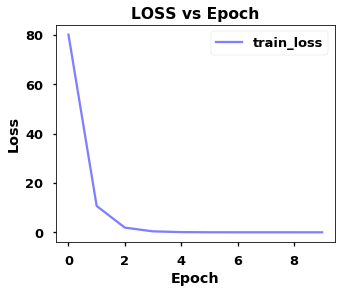

In [94]:
with mpl.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(5,4))
    plt.plot(list(range(N_EPOCHS)), loss, color='b', alpha=0.5, label='train_loss')
    # plt.plot(list(range(N_EPOCHS)), valid_ppl, color='r', alpha=0.5, label='valid_ppl')
    plt.title("LOSS vs Epoch",fontweight="bold")
    plt.xlabel("Epoch",fontweight="bold")
    plt.ylabel("Loss",fontweight="bold")
    plt.legend()
    plt.show()

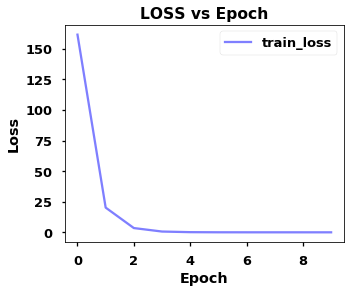

Weight Matrix Error 0.0034037229602633585
Bias error 0.00029977678907489036


In [92]:
#@title A simple linear dataset
num_features = 10 #@param {type:"slider", min:5, max:100, step:1}
num_samples = 100 #@param {type:"slider", min:10, max:1000, step:1}
epochs = 10 #@param {type:"slider", min:1, max:100, step:1}
batch_size = 10 #@param {type:"slider", min:1, max:100, step:1}
learning_rate = 0.05 #@param {type:"slider", min:0.001, max:1.0, step:0.001}

m = Linear(num_features, 1)
model = Sequential(m)
l = Learner(model, mse_loss, SGDOptimizer(lr=learning_rate))
X = np.random.randn(num_samples, num_features)
W = np.random.randn(num_features, 1)
B = np.random.randn(1)
Y = X @ W + B + 0.01 * np.random.randn(num_samples, 1)
#plt.plot(l.fit(X, Y, epochs=epochs, bs=batch_size))
with mpl.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(5,4))
    plt.plot(list(range(N_EPOCHS)), l.fit(X, Y, epochs=epochs, bs=batch_size), color='b', alpha=0.5, label='train_loss')
    # plt.plot(list(range(N_EPOCHS)), valid_ppl, color='r', alpha=0.5, label='valid_ppl')
    plt.title("LOSS vs Epoch",fontweight="bold")
    plt.xlabel("Epoch",fontweight="bold")
    plt.ylabel("Loss",fontweight="bold")
    plt.legend()
    plt.show()
print('Weight Matrix Error', np.linalg.norm(m.weights.tensor - W))
print('Bias error', np.abs(m.bias.tensor - B)[0])

We can also check that the learned weights coincide with the true ones

In [81]:
print(np.linalg.norm(model.weights.tensor - W), (model.bias.tensor - B)[0])

0.002465486371045121 0.000264120596444567


In [89]:
#@title A non-linear dataset
num_samples = 1000 #@param {type:"slider", min:100, max:10000, step:1}
epochs = 50 #@param {type:"slider", min:1, max:200, step:1}

one_layer_batch_size = 50 #@param {type:"slider", min:1, max:100, step:1}
one_layer_learning_rate = 0.01 #@param {type:"slider", min:0.001, max:1.0, step:0.001}

two_layer_batch_size = 50 #@param {type:"slider", min:1, max:100, step:1}
two_layer_learning_rate = 0.3 #@param {type:"slider", min:0.001, max:1.0, step:0.001}
hidden_neurons = 10 #@param {type:"slider", min:1, max:200, step:1}

X = np.random.randn(num_samples, 2)
Y = X[:, 0] * X[:, 1]

losses1 = Learner(
    Sequential(Linear(2, 1)), 
    mse_loss, 
    SGDOptimizer(lr=one_layer_learning_rate)).fit(X, Y, epochs=epochs, bs=one_layer_batch_size)

losses2 = Learner(
    Sequential(
        Linear(2, hidden_neurons), 
        Sigmoid(), 
        Linear(hidden_neurons, 1)
    ), mse_loss, SGDOptimizer(lr=two_layer_learning_rate)).fit(X, Y, epochs=epochs, bs=two_layer_batch_size)

plt.plot(losses1)
plt.plot(losses2)
plt.legend(['1 Layer', '2 Layers'])
plt.show()

ValueError: non-broadcastable output operand with shape (2,1) doesn't match the broadcast shape (2,50)